# LAB 8

This lab is about Stokes problem.

In [41]:
# Installation of firedrake
try:
  import firedrake
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  import firedrak

## EXERCISE 1:

Consider the Stokes problem \\

$$
  \begin{cases}
    - \Delta \boldsymbol{u}+\boldsymbol{∇}p = \boldsymbol{f} \quad \quad \text{in} \, Ω \\
    \boldsymbol{∇}⋅\boldsymbol{u}=0  \quad \quad \quad \quad \quad \text{in} \, Ω \\
    \boldsymbol{u} = \boldsymbol{g}_D \quad \quad \quad \quad \quad \text{on} \, \partialΩ
  \end{cases}
$$ \\

(a) Write the weak formulation of the problem. \\
(b)Consider the flow in a square cavity, forced by an external flow on the top boundary, and with no-slip conditions on the rest of the boundary. In this case $\boldsymbol{f}=\boldsymbol{0}$ and the vector $\boldsymbol{g}_D$ has components \\

\begin{align*}
(\boldsymbol{g}_D(x,y))_1 &= \begin{cases}
1 & \text{for $y=1$},\\
0 & \text{otherwise},
\end{cases} \\
(\boldsymbol{g}_D(x,y))_2 &= 0 .
\end{align*}

Solve the problem using Firedrake and $\mathbb{P}_1-\mathbb{P}_1$ elements with pressure stabilization. \\
(c) Solve the problem using a stable pair of finite elements.

### (a) Write the weak formulation of the problem

The weak formulation is derived by testing the first equation with a vector-valued function $\boldsymbol{v} \in H^1_0(\Omega)^2$ and the second equation with $q\in L^2_0(\Omega)$. Integrating by parts in the first equation, we obtain \\

$$
\begin{cases}
  \int_{\Omega} \boldsymbol{\nabla} \boldsymbol{u} : \boldsymbol{\nabla} \boldsymbol{v}
  - (\boldsymbol{\nabla} \cdot \boldsymbol{v}) \ p \ dx
  = \int_{\Omega} \boldsymbol{f} \cdot \boldsymbol{v} \, dx \\
  \int_\Omega (\boldsymbol{\nabla} \cdot \boldsymbol{u}) \ q \ dx = 0
\end{cases}
$$ \\

Where "$:$" is representing the inner product. \\
Subtracting the two previous equations, we obtain the weak problem: \\

\begin{equation*}
\begin{split}
\text{ Find $ (\boldsymbol{u}, p) \in$} &\; \text{$H^1(\Omega)^2 \times L^2_0(\Omega)$ such that $\boldsymbol{u}|_{\partial \Omega} = \boldsymbol{g}_D$ and} \\
a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) &= L((\boldsymbol{v}, q))
\quad \forall (\boldsymbol{v}, q) \in H^1_0(\Omega)^2 \times L^2_0,
\end{split}
\end{equation*} \\

where \\

\begin{align*} a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) &= \int_{\Omega} \boldsymbol{\nabla} \boldsymbol{u} : \boldsymbol{\nabla} \boldsymbol{v} - (\boldsymbol{\nabla} \cdot \boldsymbol{v}) \ p - (\boldsymbol{\nabla} \cdot \boldsymbol{u}) \ q \,dx, \\ L((\boldsymbol{v}, q)) &= \int_{\Omega} \boldsymbol{f} \cdot \boldsymbol{v} \, dx . \\ \end{align*} \\

This is a saddle point problem in the sense that its solution $(\mathbf{u}, p)$ is a saddle point of the Lagrangian \\

\begin{equation*}
\mathcal{L}(\mathbf{v}, q) = \dfrac{1}{2} a(\mathbf{v}, \mathbf{v}) + b(\mathbf{v}, q) - (\mathbf{f}, \mathbf{v}).
\end{equation*}

### (b) Solve the problem using Firedrake and $\mathbb{P}_1-\mathbb{P}_1$ elements with pressure stabilization

The problem with $\mathbb{P}_1-\mathbb{P}_1$ elements and without stabilization returns the following bad results:

In [42]:
from firedrake import *
import math
import matplotlib.pyplot as plt
import firedrake.pyplot as fdplt
import numpy as np
from scipy.linalg import null_space

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Text(0.5, 1.0, 'Pressure solution')

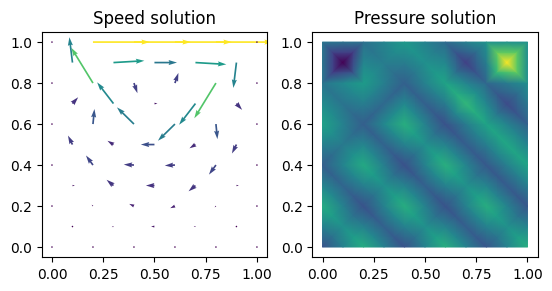

In [43]:
# Define the mesh:
n = 5
mesh = UnitSquareMesh(n, n, diagonal='crossed')


# Define the FUNCTION SPACE
V = VectorFunctionSpace(mesh, 'P', 1) # Function space of u (Unstable)
Q = FunctionSpace(mesh, 'P', 1) # Function space of q
# if P0 --> Q = FunctionSpace(mesh, 'DP', 0) #P0 element
W = V*Q # Function space of the output
# W = MixedFunctionSpace([V, Q.])


# Set Boundary Conditions and data
bcs = [DirichletBC(W.sub(0), Constant((1., 0.)), 4),
       DirichletBC(W.sub(0), Constant((0., 0.)), (1, 2, 3))]
# Handle the pressure indetermination by specifying the nullspace
# see https://www.firedrakeproject.org/solving-interface.html#singular-operators-in-mixed-spaces
# Following the documentation, we provide a basis for the nullspace of pressure
# For velocity, we pass the whole space, signifying that "we don't care about" it
nullspace = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])
f = Constant((0., 0.))


# Define Trial and Test functions:
u, p = TrialFunctions(W)
v, q = TestFunctions(W)


# Weak formulation:
# N.B. --> Here you have to use inner instead of dot because you have W as
#          multi-dimensional space:
a = inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
L = dot(f, v) * dx

# Solve the problem
w = Function(W)
solve(a==L, w, bcs, nullspace=nullspace)
u_h, p_h = w.subfunctions # Sice we have two solution in this way we extrac them
                          # one for velocity u_h and one for pressure p_h


# Plot:
fig, ax = plt.subplots(1,2)

# Plot speed:
quiver(u_h, axes=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title('Speed solution')
# Plot pressure:
tripcolor(p_h, axes=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('Pressure solution')

For $\mathbb{P}_1-\mathbb{P}_1$ elements, the solver won't give us a physical solution! This is because the nullspace we specified is not actually the whole nullspace. In addition to vectors with constant pressure, the solution contains other spurious pressure modes. \\

\\

\\

Let's therefore check how we can implement a $\mathbb{P}_1-\mathbb{P}_1$ with pressure stabilization: \\

$\mathbb{P}_1-\mathbb{P}_1$ elements do not fulfill the inf-sup condition. We can introduce a pressure stabilization term: \\

$$
s(p_h, q_h) = \delta \sum_{K \in \mathcal{T}_h} h_K^2 \int_K \nabla p_h \cdot \nabla q_h \, d\Omega.
$$ \\

This is known as the Brezzi-Pitkäranta stabilization, and it corresponds to writing the block matrix of the system as \\

$$
\begin{bmatrix}
A & B^T \\
B & - \epsilon A_p
\end{bmatrix},
$$ \\

that is, to adding a pressure stiffness matrix. It leads to a consistent scheme, since its definition includes $h_K^2$. The following convergence estimate holds (Brezzi, Pitkäranta 1984): \\

$$
\|\mathbf{u} - \mathbf{u}_h\|_{H^1} + \|p - p_h\|_{L^2} \leq C h \left( |\mathbf{u}|_{H^2} + |p|_{H^1} \right),
$$ \\

provided the exact solution $(\mathbf{u}, p)$ is regular enough to define the seminorms on the right hand side.

In [44]:
# Define the mesh:
n = 5
mesh = UnitSquareMesh(n, n, diagonal='crossed')


# Define the FUNCTION SPACE
V = VectorFunctionSpace(mesh, 'P', 1) # Function space of u (Unstable)
Q = FunctionSpace(mesh, 'P', 1) # Function space of q
W = V*Q # Function space of the output


# Set Boundary Conditions and initial data
bcs = [DirichletBC(W.sub(0), Constant((1., 0.)), 4),
       DirichletBC(W.sub(0), Constant((0., 0.)), (1, 2, 3))]
nullspace = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])
f = Constant((0., 0.))


# Define the tral and test functions:
u, p = TrialFunctions(W)
v, q = TestFunctions(W)


# Weak formulation:
# when we have the ":" product means an INNER product and not a dot one
a = inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
L = dot(f, v) * dx
#------------------- Stabilizatin term for pressure: -------------------
delta = Constant(1.)
h = CellDiameter(mesh)
a_stab = -delta * h * h * dot(grad(p), grad(q)) * dx
#-----------------------------------------------------------------------

# Solve the problem
w = Function(W)
solve(a+a_stab==L, w, bcs, nullspace=nullspace)
u_h, p_h = w.subfunctions # Get velocity and pressure from the solution

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Text(0.5, 1.0, 'Pressure solution')

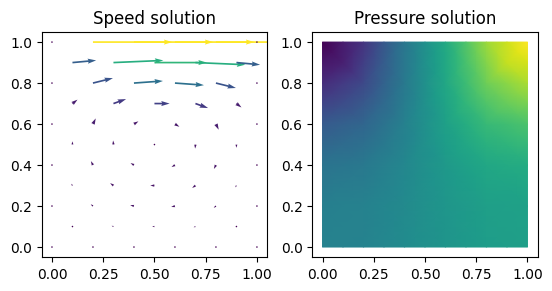

In [45]:
# Plot:
fig, ax = plt.subplots(1,2)

# Plot speed:
quiver(u_h, axes=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title('Speed solution')
# Plot pressure:
tripcolor(p_h, axes=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('Pressure solution')

### (c) Solve the problem using a stable pair of finite elements.

Let's implement a stabilization method that we can use if we don't want to use $\mathbb{P}_1-\mathbb{P}_2$ for the discretization spaces, but we use $\mathbb{P}_1-\mathbb{P}_1$.

In [46]:
# Define the mesh:
n = 5
mesh = UnitSquareMesh(n, n, diagonal='crossed')


# Define the FUNCTION SPACE
V = VectorFunctionSpace(mesh, 'P', 2) # Function space of u (Stable)
Q = FunctionSpace(mesh, 'P', 1) # Function space of q
W = V*Q # Function space of the output


# Set Boundary Conditions and initial data
bcs = [DirichletBC(W.sub(0), Constant((1., 0.)), 4),
       DirichletBC(W.sub(0), Constant((0., 0.)), (1, 2, 3))]
nullspace = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])
f = Constant((0., 0.))


# Define the tral and test functions:
u, p = TrialFunctions(W)
v, q = TestFunctions(W)


# Weak formulation:
# when we have the ":" product means an INNER product and not a dot one
a = inner(grad(u), grad(v))*dx - p*div(v)*dx - q*div(u)*dx
L = dot(f, v) * dx
#------------------- Stabilizatin term: -------------------
delta = Constant(1.)
h = CellDiameter(mesh)
a_stab = -delta * h * h * dot(grad(p), grad(q)) * dx
#----------------------------------------------------------

# Solve the problem
w = Function(W)
solve(a+a_stab==L, w, bcs, nullspace=nullspace)
u_h, p_h = w.subfunctions # Get velocity and pressure from the solution

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Text(0.5, 1.0, 'Pressure solution')

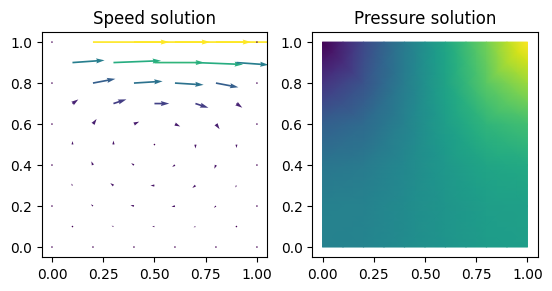

In [47]:
# Plot:
fig, ax = plt.subplots(1,2)

# Plot speed:
quiver(u_h, axes=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title('Speed solution')
# Plot pressure:
tripcolor(p_h, axes=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('Pressure solution')

See that with $\mathbb{P}_1-\mathbb{P}_2$ we have a stable solution.

## EXERCISE 2

Repeat the problem above using data \\

$$\mathbf{u}_{ex} = \begin{bmatrix}
-\cos(x) \sin(y)\\ \sin(x) \cos(y)
\end{bmatrix}$$
$$p_{ex} = - \dfrac{1}{4} [\cos(2x) + \cos(2y)] + \dfrac{1}{4} \sin(2)$$
$$\mathbf{f}_{ex} = \begin{bmatrix}
-2 \cos(x) \sin(y) + 1/2 \sin(2x)\\
2 \sin(x) \cos(y) + 1/2 \sin(2y)
\end{bmatrix}$$ \\

and verify the convergence behaviour.

In [48]:
def solve_stokes(n, degreeU, degreeP, gD_fun, f_fun, delta=0.):
  # Mesh definition
  mesh = UnitSquareMesh(n, n)

  V = VectorFunctionSpace(mesh, 'P', degreeU)
  if degreeP==0:
      Q = FunctionSpace(mesh, 'DP', 0) #P0 element
  else:
      Q = FunctionSpace(mesh, 'P', degreeP)

  W = MixedFunctionSpace([V, Q])

  x = SpatialCoordinate(mesh)
  gD = gD_fun(x)
  f = f_fun(x)

  bc = DirichletBC(W.sub(0), gD, 'on_boundary')
  nullspace = MixedVectorSpaceBasis(
      W, [W.sub(0), VectorSpaceBasis(constant=True)]
  )

  # Variational formulation
  u, p = TrialFunctions(W)
  v, q = TestFunctions(W)

  a = inner(grad(u), grad(v)) * dx - div(v) * p * dx - q * div(u) * dx
  L = dot(f, v) * dx

  # Brezzi-Pitkaranta stabilization
  h = CellDiameter(mesh)
  a_stab = Constant(delta) * h * h * dot(grad(p), grad(q)) * dx
  a -= a_stab


  # Solution
  w = Function(W)
  solve(a == L, w, bcs=bc, nullspace=nullspace)
  u_h, p_h = w.subfunctions

  #pmean = assemble(p_h*dx)
  #ph -= pmean

  return u_h, p_h, mesh

Notice that if the two lines
``pmean = assemble(ph*dx)``,
``ph -= pmean``
are commented, the mean pressure tends to zero as $h$, independently on the order of the pressure space. See Problem 4 for an explanation in the case P3-P2.

In [49]:
# Set data:
u_ex_fun = lambda x: as_vector((-cos(x[0]) * sin(x[1]), sin(x[0]) * cos(x[1])))
# The last term in p_ex_fun makes sure that the mean is zero, consistent with the definition of the nullspace
p_ex_fun = lambda x: -0.25 * (cos(2*x[0]) + cos(2*x[1])) + 0.25*sin(2)
f_fun = lambda x: as_vector((-2 * cos(x[0]) * sin(x[1]) + 0.5 * sin(2 * x[0]),
                   2 * sin(x[0]) * cos(x[1]) + 0.5 * sin(2 * x[1])))
gD_fun = u_ex_fun


# Recall the function to solve the problem
u_h, p_h, mesh = solve_stokes(5, 1, 1, gD_fun, f_fun, delta=1.) # P1/P1 elements


firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Text(0.5, 1.0, 'Pressure solution')

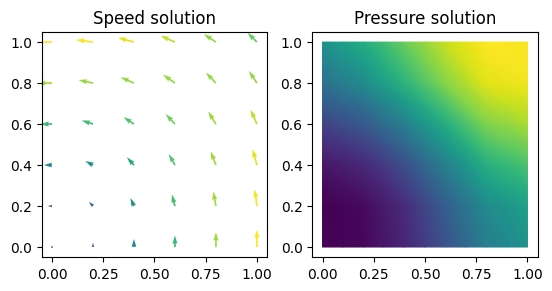

In [51]:
# Plot:
fig, ax = plt.subplots(1,2)

# Plot speed:
quiver(u_h, axes=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title('Speed solution')
# Plot pressure:
tripcolor(p_h, axes=ax[1])
ax[1].set_aspect('equal')
ax[1].set_title('Pressure solution')

For the Convergence let's consider the following theorem: \\

\\

**Theorem** (Convergence result for $\mathbb{P}_2-\mathbb{P}_1$ elements): \\

Let $\Omega$ be a bounded, plane polygon and let the exact solution $(\mathbf{u}, p)$ of the Stokes problem satisfy \\
$$ \mathbf{u} \in \left[ H^{k+1}(\Omega) \cap H^1_0(\Omega) \right]^2,
\quad p \in H^k(\Omega) \cap L^2_0(\Omega), \quad k=1, 2.$$ \\
If the triangulation is regular, then the solution of the Stokes problem using $\mathbb{P}_2-\mathbb{P}_1$ elements satisfies the estimate \\

$$ |\mathbf{u} - \mathbf{u}_h|_{H^1(\Omega)} + \|p - p_h\|_{L^2(\Omega)} \leq C_1 h^k \left( |u|_{H^{k+1}(\Omega)} + |p|_{H^k(\Omega)} \right), \quad k=1,2. $$ \\
If the domain is also convex: \\

$$ \|\mathbf{u} - \mathbf{u}_h\|_{L^2(\Omega)} \leq C_2 h^{k+1} \left( |u|_{H^{k+1}(\Omega)} + |p|_{H^k(\Omega)} \right), \quad k=1,2.$$ \\

With the assumption that the triangulation is uniformly regular, and even if the domain is not convex, \\

$$ |p - p_h|_{H^1(\Omega)} \leq C_3 h^{k-1} \left( |u|_{H^{k+1}(\Omega)} + |p|_{H^k(\Omega)} \right), \quad k=1,2. $$ \\

See V. Girault, P.-A. Raviart, *Finite Element Methods for Navier-Stokes Equations*, Springer-Verlag 1986, p.181

In [58]:
u_h, p_h, mesh = solve_stokes(5, 2, 1, gD_fun, f_fun, delta=1.) # P2/P1 elements


# Recall the exact solutions
x = SpatialCoordinate(mesh)
p_ex = p_ex_fun(x)
u_ex = u_ex_fun(x)

print('L2 error on p = ', errornorm(p_ex, p_h, 'L2'))
print('L2 error on u = ', errornorm(u_ex, u_h, 'L2'))
print('H1 error on u = ', errornorm(u_ex, u_h, 'H1'))

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


L2 error on p =  0.10605045304132456
L2 error on u =  0.014762030967589454
H1 error on u =  0.07038393321849593


## EXERCISE 3

Verify the Poiseuille solution for viscous channel flow. Build a rectangular domain using the
following command: mesh = RectangleMesh(nx, ny, L, H, diagonal=’crossed’). Enforce
a condition of uniform flow on the left boundary, no-slip on the top and bottom boundaries, and
the do-nothing condition on the right boundary.

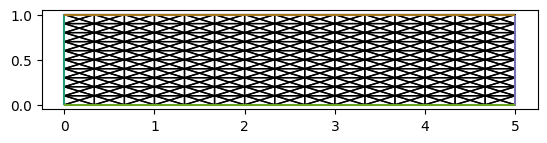

In [69]:
# This part was given by the professor and is the problem setting + mesh:

# Physical parameters
mu = Constant(1e-3)
f = Constant((0., 0.))

# Geometry
L = 5.
H = 1.
nx = 15
ny = 10

mesh = RectangleMesh(nx, ny, L, H, diagonal='crossed')
# The boundary edges in this mesh are numbered as follows:
# 1: plane x == 0   -> Dirichlet, inlet
# 2: plane x == Lx  -> do-nothing
# 3: plane y == 0   -> Dirichlet, no-slip
# 4: plane y == Ly  -> Dirichlet, no-slip
# see https://firedrakeproject.org/firedrake.html#firedrake.utility_meshes.RectangleMesh


fig, ax = plt.subplots()
fdplt.triplot(mesh, axes=ax)
ax.set_aspect('equal')
plt.show()

In [70]:
# Set function-spaces
V = VectorFunctionSpace(mesh, 'CG', 2)
Q = FunctionSpace(mesh, 'CG', 1)
W = V*Q


# Boundary conditions
bc_left = DirichletBC(W.sub(0), as_vector([1., 0.]), 1) # Uniform flow
bc_lower = DirichletBC(W.sub(0), as_vector([0., 0.]), 3) # no-slip
bc_upper = DirichletBC(W.sub(0), as_vector([0., 0.]), 4) # no-slip
# Handle the pressure indetermination by specifying the nullspace
nullspace = MixedVectorSpaceBasis(
    W, [W.sub(0), VectorSpaceBasis(constant=True)])


# Pre-difine trial and test functions
u, p = TrialFunctions(W)
v, q = TestFunctions(W)


# Weak formulation
a = mu * inner(grad(u), grad(v)) * dx - p * div(v) * dx - div(u) * q * dx
L = dot(f, v) * dx

# Solve the problem
w = Function(W)
solve(a == L, w, bcs=[bc_left, bc_lower, bc_upper], nullspace=nullspace)
u_h, p_h = w.subfunctions # Get pressure and velocity

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


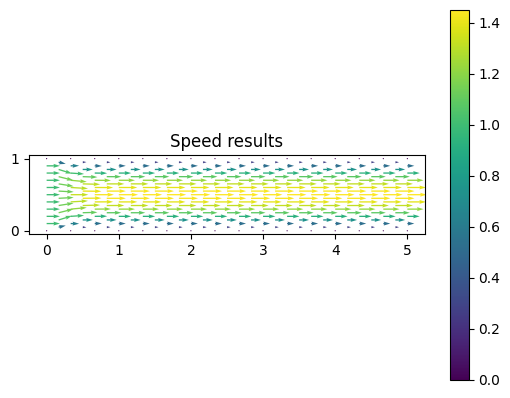

In [71]:
fig, ax = plt.subplots()
q = fdplt.quiver(u_h, axes=ax)
ax.set_aspect('equal')
ax.set_title('Speed results')
plt.colorbar(q)
plt.show()

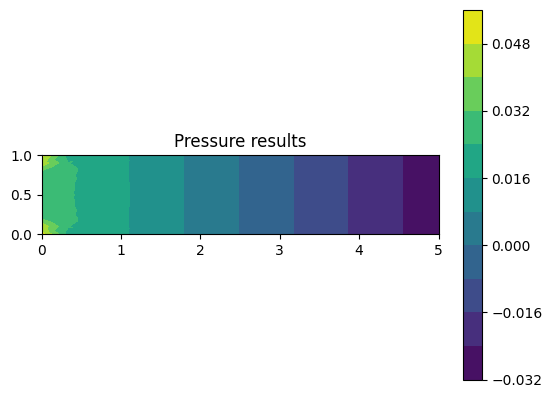

In [73]:
# Plots
fig, ax = plt.subplots()
q = fdplt.tricontourf(p_h, axes=ax, levels=10)
ax.set_aspect('equal')
ax.set_title('Pressure results')
plt.colorbar(q)
plt.show()

This following part was not required:

In [75]:
# Plot the velocity profile, using command "at" of firedrake
N = 20
x = 3
y = np.linspace(0+1e-6, 1-1e-6, N) #errors are raised for extreme values...
u_section = [u_h.at([x, y[i]], dont_raise=True)[0] for i in range(N)]

u_ex = lambda y: 6/(H*H) * y * (H - y)

# Plot
fig, ax = plt.subplots()
ax.plot(u_section, y, label='Numerical solution')
ax.plot(u_ex(y), y, label='Exact solution')
ax.legend()
ax.set_ylabel('y')
ax.set_xlabel('u')

## EXERCISE 4

Consider the following Stokes problem \\

$$
  \begin{cases}
    - \Delta \boldsymbol{u}+\boldsymbol{∇}p = \boldsymbol{f} \quad \quad \text{in} \, Ω \\
    \boldsymbol{∇}⋅\boldsymbol{u}=0  \quad \quad \quad \quad \quad \text{in} \, Ω \\
    \boldsymbol{u} = \boldsymbol{g}_D \quad \quad \quad \quad \quad \text{on} \, \partialΩ
  \end{cases}
$$ \\

(a) Consider $f = [0, −y]$ and the exact velocity solution $u_{ex} = [x^2 + y^, -2xy]$. Verify that $u_{ex}$ is divergence-free and compute the corresponding zero-mean pressure solution $p_{ex}$. \\
(b) Write the weak formulation of the problem. \\
(c) Solve the problem with Firedrake using $\mathbb{P}_2$ finite elements for the velocity and $\mathbb{P}_1$ finite
elements for the pressure. \\
(d) Verify the order of convergence for velocity in the $H^1$ norm with respect to the grid size. \\
(e) Solve the problem with Firedrake using $\mathbb{P}_1-\mathbb{P}_1$ elements and the penalty stabilization method (pressure mass matrix).
